# Plot subhalos

In [12]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from simulation.wrapper import augmented_data
from simulation.units import M_s
import astropy

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

In [13]:
astropy.__version__

'3.1.2'

## Settings

In [14]:
n_cols = 4
n_rows = 5

## Make data

In [15]:
theta, imgs, t_xz, log_r_xz, sub_latents, global_latents = augmented_data(
    f_sub=0.05, beta=-1.9, n_images=n_cols*n_rows, mine_gold=True,
    draw_alignment=True, draw_host_mass=True, draw_host_redshift=True
)

17:18 simulation.wrapper   INFO    Simulating image 1 / 20
17:18 simulation.wrapper   INFO    Simulating image 2 / 20
17:18 simulation.wrapper   INFO    Simulating image 3 / 20
17:18 simulation.wrapper   INFO    Simulating image 4 / 20
17:18 simulation.wrapper   INFO    Simulating image 5 / 20
17:18 simulation.wrapper   INFO    Simulating image 6 / 20
17:18 simulation.wrapper   INFO    Simulating image 7 / 20
17:18 simulation.wrapper   INFO    Simulating image 8 / 20
17:18 simulation.wrapper   INFO    Simulating image 9 / 20
17:18 simulation.wrapper   INFO    Simulating image 10 / 20
17:18 simulation.wrapper   INFO    Simulating image 11 / 20
17:18 simulation.wrapper   INFO    Simulating image 12 / 20
17:18 simulation.wrapper   INFO    Simulating image 13 / 20
17:18 simulation.wrapper   INFO    Simulating image 14 / 20
17:18 simulation.wrapper   INFO    Simulating image 15 / 20
17:18 simulation.wrapper   INFO    Simulating image 16 / 20
17:18 simulation.wrapper   INFO    Simulating ima

## Plot subhalos

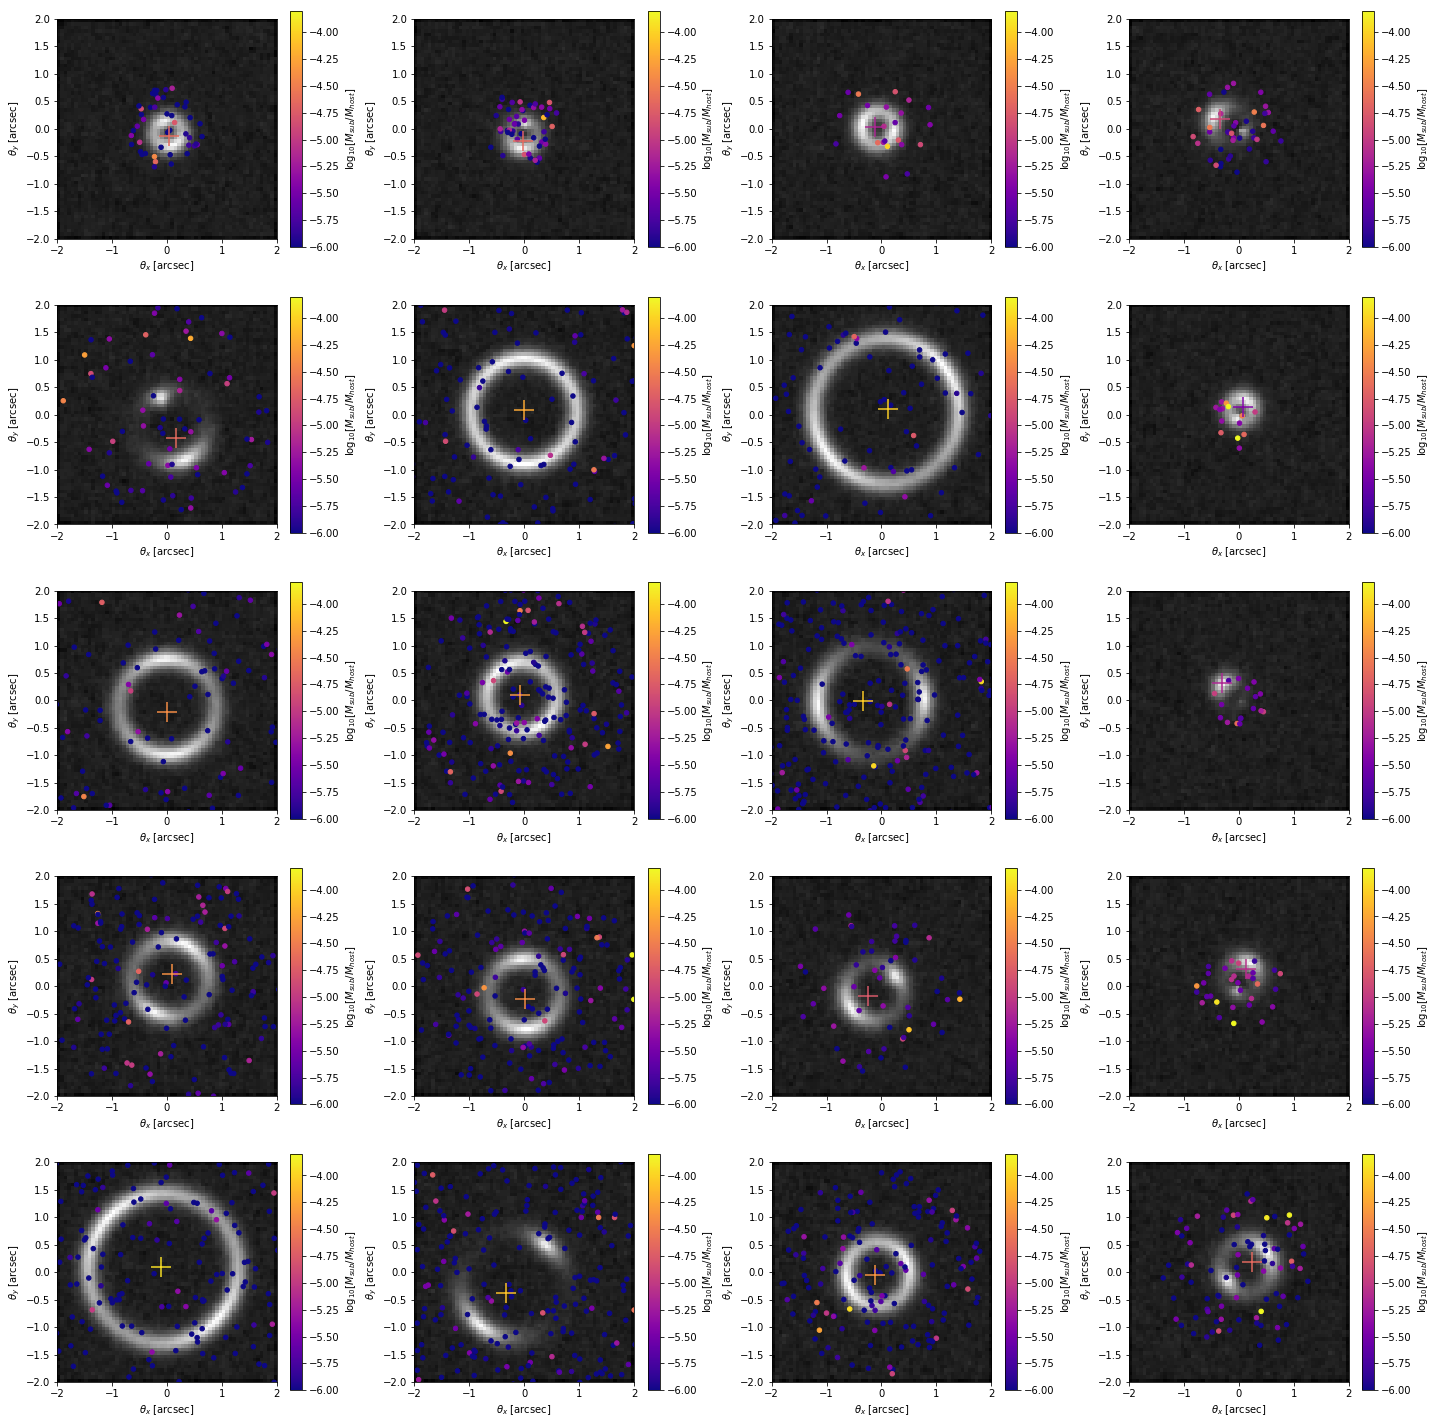

In [16]:
plt.figure(figsize=(n_cols*5.,n_rows*4.))

for i in range(n_cols*n_rows):
    ax = plt.subplot(n_rows,n_cols,i+1)
        
    plt.imshow(
        np.log10(imgs[i]),
        vmin=2.3,
        vmax=3.2,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    sc = plt.scatter(
        sub_latents[i][:,1],
        sub_latents[i][:,2],
        s=20.,
        c=np.log10(sub_latents[i][:,0] / global_latents[i,0]),
        cmap="plasma",
        vmin=-6.,
        vmax=-3.8,
    )
    plt.scatter(
        [global_latents[i,4]],
        [global_latents[i,5]],
        s=400.,
        marker="+",
        c=[np.log10(global_latents[i,0] / (M_s))],
        cmap="plasma",
        vmin=12.,
        vmax=14.,
    )
    cbar = plt.colorbar(sc)
    
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)

    plt.xlabel(r"$\theta_x$ [arcsec]")
    plt.ylabel(r"$\theta_y$ [arcsec]")
    cbar.set_label(r'$\log_{10} [M_{sub} / M_{host}]$')
    
    
plt.tight_layout()
plt.savefig("../figures/subhalos.pdf")